## Traversing a Directory to Locate and Print File Paths

In [2]:
import numpy as np
import pandas as pd

import os

# Define the root directory where your dataset is located
root_directory = r"D:\Master Course\Sem Two\Big Data Management And Data Visualisation\Dataset"

# Traverse the directory tree starting from root_directory
for dirname, _, filenames in os.walk(root_directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\Master Course\Sem Two\Big Data Management And Data Visualisation\Dataset\heart_failure_clinical_records_dataset.csv


# Importing Necessary Libraries and Packages for PySpark

In [3]:
# Importing the Package
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler

# Loading Data into PySpark DataFrame

In [4]:
# Initialize SparkSession
spark=SparkSession.builder.master('local').appName("Heart Failure").getOrCreate()
# Load data from CSV into a DataFrame
data=spark.read.csv("D:\Master Course\Sem Two\Big Data Management And Data Visualisation\Dataset\heart_failure_clinical_records_dataset.csv", inferSchema=True, header=True)
data.show(truncate=False, n=5)

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|age |anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|75.0|0      |582                     |0       |20               |1                  |265000.0 |1.9             |130         |1  |0      |4   |1          |
|55.0|0      |7861                    |0       |38               |0                  |263358.03|1.1             |136         |1  |0      |6   |1          |
|65.0|0      |146                     |0       |20               |0                  |162000.0 |1.3             |129         |1  |1      |7   |1          |
|50.0|1      |111                     |0       |20              

In [5]:
# Check the schema of the DataFrame
data.printSchema()

root
 |-- age: double (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- creatinine_phosphokinase: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- ejection_fraction: integer (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- platelets: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- serum_sodium: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- smoking: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)



# Checking Null Values in the Data

In [6]:
from pyspark.sql.functions import *

data.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in data.columns]).show()

+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|  0|      0|                       0|       0|                0|                  0|        0|               0|           0|  0|      0|   0|          0|
+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+



In [7]:
data.count()

999

# Data Preparation and Splitting for Machine Learning in PySpark

In [8]:
# Split the data into training and test sets
data_split = data.randomSplit([0.7, 0.3], seed= 123)  # 70% for training, 30% for testing

# Assign training and test sets
train = data_split[0]
test = data_split[1]

# Print the counts of records in each set
print("Train data count:", train.count())
print("Test data count:", test.count())

Train data count: 686
Test data count: 313


# Feature Engineering Using VectorAssembler in PySpark

In [9]:
#'train' is already defined as the training DataFrame
train.show(2)

# Define a VectorAssembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=['age', 'anaemia', 'creatinine_phosphokinase',
                                       'diabetes', 'ejection_fraction', 'high_blood_pressure',
                                       'platelets', 'serum_creatinine', 'serum_sodium',
                                       'sex', 'smoking', 'time'],
                            outputCol='features')

# Transform the training data using the VectorAssembler
trainingdatafinal = assembler.transform(train).select(col('features'), col('DEATH_EVENT').alias('label'))
testdatafinal = assembler.transform(test).select(col('features'), col('DEATH_EVENT').alias('label'))
# Show the transformed data with features and labels
trainingdatafinal.show(truncate=False, n=5)
testdatafinal.show(truncate=False, n=5)

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
| age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|40.0|      0|                      90|       0|               35|                  0| 255000.0|             1.1|         136|  1|      1| 212|          0|
|40.0|      0|                     244|       0|               45|                  1| 275000.0|             0.9|         140|  0|      0| 174|          0|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
only showing top 2 rows

+--------------------------------------

# Apply Classification Algorithms

In [10]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Logistic Regression
# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Fit the model on training data
lr_model = lr.fit(trainingdatafinal)

# Predict on test data
lr_predictions = lr_model.transform(testdatafinal)

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
# Evaluate the model using MulticlassClassificationEvaluator for Confusion Matrix
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions)
print("Logistic Regression Accuracy:", accuracy)

# Calculate Confusion Matrix
conf_matrix = lr_predictions.groupBy('label', 'prediction').count()
conf_matrix.show()


Logistic Regression Accuracy: 0.8785942492012779
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   24|
|    0|       0.0|  208|
|    1|       1.0|   67|
|    0|       1.0|   14|
+-----+----------+-----+



Area Under ROC: 0.9032274032274028


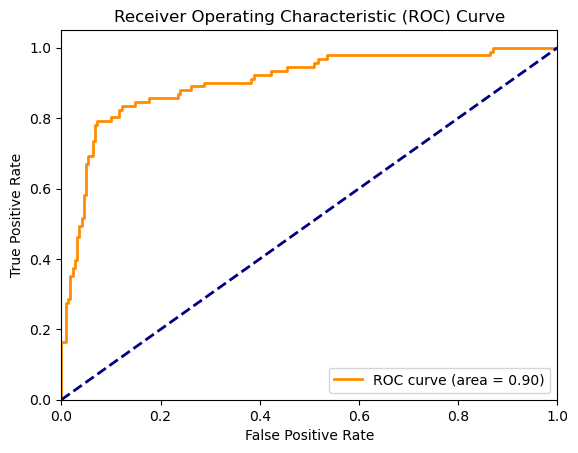

In [12]:
# Evaluate the model using BinaryClassificationEvaluator for ROC Curve
evaluator_roc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator_roc.evaluate(lr_predictions)
print("Area Under ROC:", roc_auc)

# Plot ROC Curve (assuming you have probabilities for ROC curve)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract probability for class 1 (positive class)
lr_prob = lr_predictions.select('probability').rdd.map(lambda x: x['probability'][1]).collect()
y_true = lr_predictions.select('label').rdd.map(lambda x: x['label']).collect()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, lr_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
#Random Forest Classifier
# Initialize Random Forest Classifier model
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Fit the model on training data
rf_model = rf.fit(trainingdatafinal)

# Predict on test data
rf_predictions = rf_model.transform(testdatafinal)

In [14]:
# Evaluate the model using MulticlassClassificationEvaluator for Confusion Matrix
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(rf_predictions)
print("Random Forest Classifier Accuracy:", accuracy_rf)

# Calculate Confusion Matrix
conf_matrix_rf = rf_predictions.groupBy('label', 'prediction').count()
conf_matrix_rf.show()

Random Forest Classifier Accuracy: 0.9041533546325878
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   17|
|    0|       0.0|  209|
|    1|       1.0|   74|
|    0|       1.0|   13|
+-----+----------+-----+



Area Under ROC (Random Forest): 0.9388921888921901


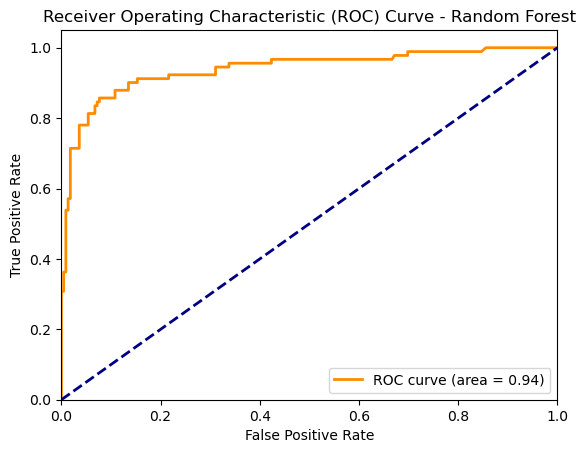

In [15]:
# Evaluate the model using BinaryClassificationEvaluator for ROC Curve
evaluator_roc_rf = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc_rf = evaluator_roc_rf.evaluate(rf_predictions)
print("Area Under ROC (Random Forest):", roc_auc_rf)

# Plot ROC Curve (assuming you have probabilities for ROC curve)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract probability for class 1 (positive class)
rf_prob = rf_predictions.select('probability').rdd.map(lambda x: x['probability'][1]).collect()
y_true_rf = rf_predictions.select('label').rdd.map(lambda x: x['label']).collect()

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true_rf, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve for Random Forest
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Decision Tree Classifier
# Initialize Decision Tree Classifier model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# Fit the model on training data
dt_model = dt.fit(trainingdatafinal)

# Predict on test data
dt_predictions = dt_model.transform(testdatafinal)

In [17]:
# Evaluate the model using MulticlassClassificationEvaluator for Confusion Matrix
evaluator_dt = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy_dt = evaluator_dt.evaluate(dt_predictions)
print("Decision Tree Classifier Accuracy:", accuracy_dt)

# Calculate Confusion Matrix
conf_matrix_dt = dt_predictions.groupBy('label', 'prediction').count()
conf_matrix_dt.show()

Decision Tree Classifier Accuracy: 0.9073482428115016
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   17|
|    0|       0.0|  210|
|    1|       1.0|   74|
|    0|       1.0|   12|
+-----+----------+-----+



Area Under ROC (Decision Tree): 0.8075190575190575


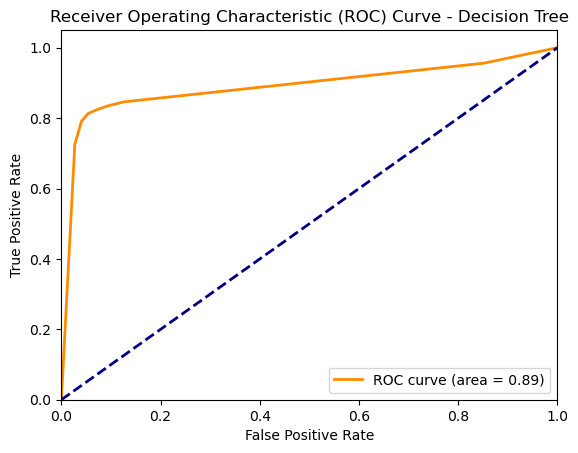

In [18]:
# Evaluate the model using BinaryClassificationEvaluator for ROC Curve
evaluator_roc_dt = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc_dt = evaluator_roc_dt.evaluate(dt_predictions)
print("Area Under ROC (Decision Tree):", roc_auc_dt)

# Plot ROC Curve (assuming you have probabilities for ROC curve)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract probability for class 1 (positive class)
dt_prob = dt_predictions.select('probability').rdd.map(lambda x: x['probability'][1]).collect()
y_true_dt = dt_predictions.select('label').rdd.map(lambda x: x['label']).collect()

# Calculate ROC curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_true_dt, dt_prob)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve for Decision Tree
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Summary Table

In [19]:
from tabulate import tabulate
import pandas as pd

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(featuresCol='features', labelCol='label'),
    "Random Forest Classifier": RandomForestClassifier(featuresCol='features', labelCol='label'),
    "Decision Tree Classifier": DecisionTreeClassifier(featuresCol='features', labelCol='label')
}
# Storage for results
results = []
# Iterate over each model
for name, model in models.items():
    # Fit the model
    model_fit = model.fit(trainingdatafinal)
    # Predictions
    predictions = model_fit.transform(testdatafinal)
    # Accuracy
    evaluator_acc = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
    accuracy = evaluator_acc.evaluate(predictions)
    # Confusion Matrix
    conf_matrix = predictions.groupBy('label', 'prediction').count()
    # ROC AUC
    evaluator_roc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    roc_auc = evaluator_roc.evaluate(predictions)
    # Store results in a tuple
    results.append((name, accuracy, conf_matrix, roc_auc))
# Convert results to Pandas DataFrame
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Confusion Matrix", "ROC AUC"])
# Display the results table using tabulate
print(tabulate(df_results, headers='keys', tablefmt='pretty'))

+---+--------------------------+--------------------+----------------------------------------------------------+--------------------+
|   |          Model           |      Accuracy      |                     Confusion Matrix                     |      ROC AUC       |
+---+--------------------------+--------------------+----------------------------------------------------------+--------------------+
| 0 |   Logistic Regression    | 0.8785942492012779 | DataFrame[label: int, prediction: double, count: bigint] | 0.9032274032274028 |
| 1 | Random Forest Classifier | 0.9041533546325878 | DataFrame[label: int, prediction: double, count: bigint] | 0.9388921888921901 |
| 2 | Decision Tree Classifier | 0.9073482428115016 | DataFrame[label: int, prediction: double, count: bigint] | 0.8075190575190575 |
+---+--------------------------+--------------------+----------------------------------------------------------+--------------------+
